In [2]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/GEARS/demo/")
print(os.getcwd())
import sys
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from gears import PertData
from gears.inference import evaluate, compute_metrics, deeper_analysis

pert_data = PertData('./data')
pert_data.load(data_path = './data/boli')
pert_data.prepare_split(split = 'simulation_single', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

from gears import GEARS
gears_model = GEARS(pert_data, device = 'cuda:3',
                    weight_bias_track = True, 
                    proj_name = 'gears', 
                    exp_name = 'boli_uncertain')

## train a uncertainty-aware model, specify uncertainty to True
gears_model.model_initialize(uncertainty = True)
gears_model.train(epochs = 20)
gears_model.save_model('boli_unc')

## load a pretrained uncertainty model
#gears_model.load_pretrained('pertnet_unc')

/gpfs/group/jin/asun/get/GEARS/demo


Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['TRIO+ctrl' 'DAB1+ctrl' 'CX3CL1+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


here1


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Found local copy...
Start Training...
Epoch 1 Step 1 Train Loss: 1.7223
Epoch 1 Step 51 Train Loss: 0.5845
Epoch 1 Step 101 Train Loss: 0.6418
Epoch 1 Step 151 Train Loss: 0.5924
Epoch 1 Step 201 Train Loss: 0.5198
Epoch 1 Step 251 Train Loss: 0.4784
Epoch 1 Step 301 Train Loss: 0.5865
Epoch 1 Step 351 Train Loss: 0.5926
Epoch 1 Step 401 Train Loss: 0.6236
Epoch 1 Step 451 Train Loss: 0.5001
Epoch 1 Step 501 Train Loss: 0.5246
Epoch 1 Step 551 Train Loss: 0.6100
Epoch 1 Step 601 Train Loss: 0.4758
Epoch 1: Train Overall MSE: 0.0021 Validation Overall MSE: 0.0012. 
Train Top 20 DE MSE: 0.0146 Validation Top 20 DE MSE: 0.0131. 
Epoch 2 Step 1 Train Loss: 0.4762
Epoch 2 Step 51 Train Loss: 0.4993
Epoch 2 Step 101 Train Loss: 0.5923
Epoch 2 Step 151 Train Loss: 0.6383
Epoch 2 Step 201 Train Loss: 0.5578
Epoch 2 Step 251 Train Loss: 0.5375
Epoch 2 Step 301 Train Loss: 0.4135
Epoch 2 Step 351 Train Loss: 0.4576
Epoch 2 Step 401 Train Loss: 0.5708
Epoch 2 Step 451 Train Loss: 0.4965
Epoch 2 S

In [3]:
test_res = evaluate(gears_model.dataloader['test_loader'], gears_model.model, gears_model.config['uncertainty'], gears_model.device)
test_metrics, test_pert_res = compute_metrics(test_res)
out = deeper_analysis(gears_model.adata, test_res)

In [8]:
test_pert_res

{'HERC1+ctrl': {'mse': 0.00033632587,
  'pearson': 0.9978207358797686,
  'mse_de': 0.00613614,
  'pearson_de': 0.9984036956661839},
 'SATB2+ctrl': {'mse': 0.00054565625,
  'pearson': 0.9964640239172022,
  'mse_de': 0.0259642,
  'pearson_de': 0.9855048482568236}}

In [4]:
pert2unc = pd.DataFrame(tuple(zip(test_res['pert_cat'], np.mean(test_res['logvar'], axis = 1)))).groupby(0).agg(np.mean)
pert2unc = dict(zip(pert2unc.index.values, pert2unc.values))

metric = 'pearson_delta'
stats_summary = [np.exp(-pert2unc[i][0]) for i in test_pert_res.keys() if metric in out[i]]
metric_summary = [out[i][metric] for i in test_pert_res.keys() if metric in out[i]]
print(pearsonr(stats_summary, metric_summary))

PearsonRResult(statistic=-1.0, pvalue=1.0)


In [7]:
stats_summary

[0.70449334, 0.6702517]

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette("Set2").as_hex()

def plot(stats_summary, metric_summary):

    ax = sns.regplot(x=np.array(stats_summary),
                    y=np.array(metric_summary), 
                    color = pal[2],
                     ci = None
                    )

    sns.despine()

    plt.ylabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.xlabel("Predicted Uncertainty",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('uncertainty.pdf', bbox_inches='tight')
    
    plt.show()
    
    top = np.quantile(np.array(list(pert2unc.values())), 0.95)

    m = 'pearson_delta'
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)], hist = False, color = "black")
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)], hist = False, color = "Red")

    print('---- ' + m + '----')
    total_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)])
    after_filter_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)])
    print('Total Mean: ' + str(total_mean))
    print('After uncertainty filter Mean: ' + str(after_filter_mean))
    print('Enrichment: ' + str((after_filter_mean - total_mean)/total_mean))

    sns.despine()
    ax.set_xlim((-0.24,1.24))
    plt.xlabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.ylabel("Density of Perturbations",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('prioritize_uncertainty.pdf', bbox_inches='tight')
    plt.show()


In [18]:
out

{'HERC1+ctrl': {'frac_correct_direction_all': 0.5068,
  'frac_correct_direction_20': 0.55,
  'frac_correct_direction_50': 0.6,
  'frac_correct_direction_100': 0.58,
  'frac_correct_direction_200': 0.595,
  'frac_correct_direction_20_nonzero': 0.9,
  'frac_in_range': 1.0,
  'frac_in_range_45_55': 0.35,
  'frac_in_range_40_60': 0.45,
  'frac_in_range_25_75': 0.7,
  'mean_sigma': 0.10778216,
  'std_sigma': 0.053027775,
  'frac_sigma_below_1': 1.0,
  'frac_sigma_below_2': 1.0,
  'pearson_delta': 0.18148090796616978,
  'pearson_delta_de': 0.6460986530291848,
  'fold_change_gap_all': 0.046149556,
  'pearson_delta_top200_hvg': 0.2353064687727624,
  'pearson_top200_hvg': 0.9971374042382877,
  'mse_top200_hvg': 0.0034020084,
  'pearson_delta_top20_de': 0.6460986530291848,
  'pearson_top20_de': 0.9984036167275008,
  'mse_top20_de': 0.006136141,
  'pearson_delta_top200_de': 0.37180018626301603,
  'pearson_top200_de': 0.9971628634492049,
  'mse_top200_de': 0.0018642972,
  'pearson_delta_top100_de'

In [15]:
pert2unc

{'HERC1+ctrl': array([0.35027638], dtype=float32),
 'SATB2+ctrl': array([0.4001019], dtype=float32)}

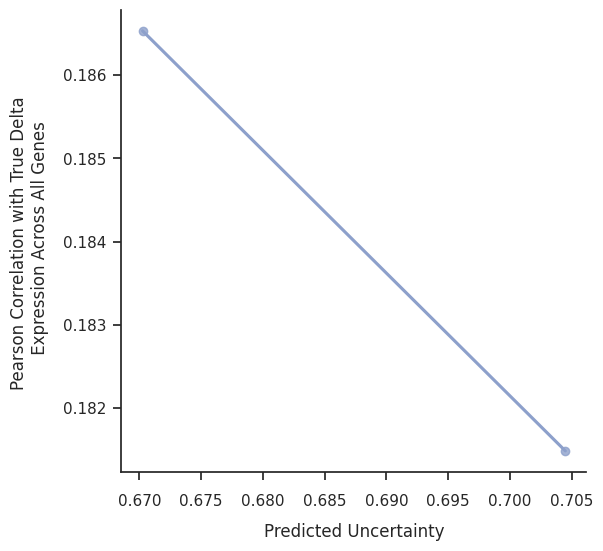

---- pearson_delta----
Total Mean: 0.18148090796616978
After uncertainty filter Mean: 0.18653519253560225
Enrichment: 0.027850227476130134


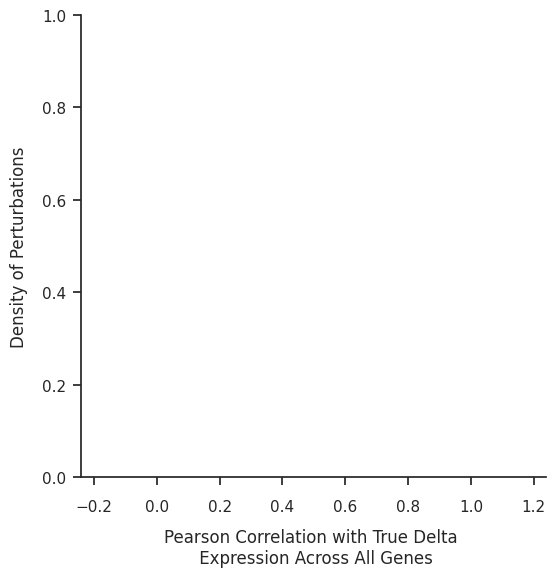

In [19]:
plot(stats_summary, metric_summary)